## Классификация MNIST

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

Давайте обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В этом задании мы воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплайн обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку с первого занятия.

Мы настоятельно рекомендуем писать код «с нуля», лишь изредка подглядывая в готовые примеры, а не просто «копировать-вставлять». Это поможет вам в будущем.

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.13MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.10MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.03MB/s]


Text(0.5, 1.0, 'Image label: 3')

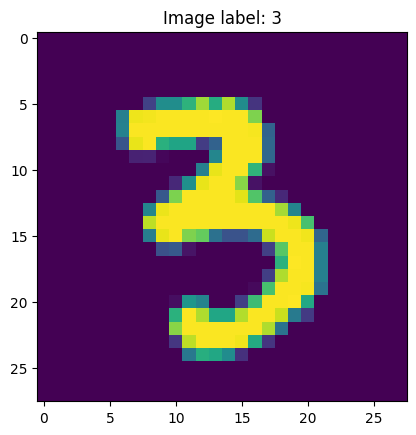

In [2]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Постройте модель, представленную ниже. Пожалуйста, не создавайте чрезмерно сложную сеть — она не должна быть глубже четырёх слоёв (можно и меньше). Ваша основная задача — обучить модель и добиться как минимум 92% точности на тестовой выборке (hold-out выборке).

*Примечание: линейных слоёв и функций активации должно быть достаточно.*

__Обратите внимание, ваша модель должна быть представлена переменной `model`__

In [6]:
class MNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 2048)
        self.fc4 = nn.Linear(2048, 10)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

In [7]:
# Creating model instance
model = MNISTNet() # your code here

Ниже доступны локальные тесты для проверки вашей модели:

In [8]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)
except Exception as e:
    print('Something is wrong with the model')
    raise e


assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Обучите модель на обучающей выборке. Рекомендуем поэкспериментировать с различными оптимизаторами.


In [9]:
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

train_dataset = train_mnist_data
train_size = int(0.95 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Создаем новые DataLoader'ы
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Инициализация модели и оптимизатора
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MNISTNet().to(device)
optimizer = optim.Adam(model.parameters(), eps=1e-4, weight_decay=1e-5, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

# Обучение
num_epochs = 100
best_val_acc = 0.0

for epoch in range(num_epochs):
    # Тренировка
    model.train()
    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

    for images, labels in progress_bar:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Валидация
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Сохраняем лучшую модель
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_mnist_model.pth')

Epoch 1/100: 100%|██████████| 1782/1782 [00:16<00:00, 111.18it/s, loss=0.9390]


Epoch 1: Train Loss: 0.7345, Val Loss: 0.2432, Val Acc: 92.23%


Epoch 2/100: 100%|██████████| 1782/1782 [00:15<00:00, 114.37it/s, loss=0.7124]


Epoch 2: Train Loss: 0.2008, Val Loss: 0.1808, Val Acc: 94.20%


Epoch 3/100: 100%|██████████| 1782/1782 [00:15<00:00, 111.83it/s, loss=0.0057]


Epoch 3: Train Loss: 0.1412, Val Loss: 0.1219, Val Acc: 96.30%


Epoch 4/100: 100%|██████████| 1782/1782 [00:15<00:00, 116.54it/s, loss=0.4426]


Epoch 4: Train Loss: 0.1112, Val Loss: 0.1105, Val Acc: 96.87%


Epoch 5/100: 100%|██████████| 1782/1782 [00:15<00:00, 116.11it/s, loss=0.0019]


Epoch 5: Train Loss: 0.0928, Val Loss: 0.0940, Val Acc: 97.33%


Epoch 6/100: 100%|██████████| 1782/1782 [00:16<00:00, 110.09it/s, loss=0.0052]


Epoch 6: Train Loss: 0.0754, Val Loss: 0.0812, Val Acc: 97.67%


Epoch 7/100: 100%|██████████| 1782/1782 [00:15<00:00, 116.48it/s, loss=0.0022]


Epoch 7: Train Loss: 0.0667, Val Loss: 0.0792, Val Acc: 97.80%


Epoch 8/100: 100%|██████████| 1782/1782 [00:15<00:00, 116.65it/s, loss=0.1532]


Epoch 8: Train Loss: 0.0558, Val Loss: 0.0736, Val Acc: 97.73%


Epoch 9/100:  34%|███▍      | 609/1782 [00:05<00:11, 103.85it/s, loss=0.0368]


KeyboardInterrupt: 

Также помните, что вы всегда можете обратиться к отличной [документации](https://pytorch.org/docs/stable/index.html) и [учебным материалам](https://pytorch.org/tutorials/).

Оценим качество классификации:

In [11]:
model = model.to('cpu')

predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [12]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.98727


In [13]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [14]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9772


Проверка, что пороги пройдены:

In [15]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model`, а файл `hw_mnist_data_dict.npy` находится в той же директории, что и ноутбук (он доступен в репозитории).

In [17]:
# do not change the code in the block below
# __________start of block__________
import os
import json
assert os.path.exists('/content/hw_mnist_data_dict.npy'), 'Please, download `hw_mnist_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))

    predicted_labels = torch.cat(predicted_labels).numpy()
    predicted_labels = ','.join([str(x) for x in list(predicted_labels)])
    return predicted_labels

loaded_data_dict = np.load('/content/hw_mnist_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test']))
}

with open('/content/submission_dict_mnist_task_1.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict_mnist_task_1.json`')
# __________end of block__________

File saved to `submission_dict_mnist_task_1.json`


### Сдача задания
Сдайте сгенерированный файл в соответствующую задачу в соревновании, а именно:
    
* `submission_dict_mnist_task_1.json` в задачу Warmup (hw_mnist)

На этом задание завершено. Поздравляем!